In [126]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.patches as mpatches

In [127]:
project_root = os.path.abspath(os.getcwd())

data_dir = os.path.join(os.path.dirname(project_root))

results_dir = os.path.join(data_dir, 'results')

figures_dir = os.path.join(data_dir, 'figures')

# read results
results_basecase_summer = pd.read_csv(os.path.join(results_dir, 'results_basecase_summer.csv'),sep=',')
results_basecase_winter = pd.read_csv(os.path.join(results_dir, 'results_basecase_winter.csv'), sep=',')
results_case_1_winter = pd.read_csv(os.path.join(results_dir, 'results_case_1_winter.csv'), sep=',')
results_case_2_summer = pd.read_csv(os.path.join(results_dir,'results_case_2_summer.csv'), sep=',')
results_case_2_winter = pd.read_csv(os.path.join(results_dir,'results_case_2_winter.csv'), sep=',')
results_case_3_winter = pd.read_csv(os.path.join(results_dir,'results_case_3_winter.csv'), sep=',')
results_case_3_summer = pd.read_csv(os.path.join(results_dir,'results_case_3_summer.csv'), sep=',')


In [128]:
#print column names of all the dfs
print('results_basecase_summer' , results_basecase_summer.columns)
print('results_case_1_winter' , results_case_1_winter.columns)
print('results_case_2_summer' , results_case_2_summer.columns)
print('results_case_3_summer' , results_case_3_summer.columns)#

results_basecase_summer Index(['timestamp', 'Spotmarket_(EUR/kWh)', 'Inflexible_Demand_(kWh)',
       'PV_energy_production_kWh', 'ev_at_home_binary', 'distance_driven',
       'ev_home_availability', 'weekday', 'Allowed_WM_summer', 'Allowed_dryer',
       'Total_Demand', 'Dishwasher_Start', 'Dishwasher_On',
       'Washing_Machine_Start', 'Washing_Machine_On', 'Dryer_Start',
       'Dryer_On', 'EV_SOC', 'EV_Charging', 'EV_On', 'Demand_Level',
       'Penalty_Cost', 'Electricity_Cost', 'Total_Cost'],
      dtype='object')
results_case_1_winter Index(['timestamp', 'Spotmarket_(EUR/kWh)', 'Inflexible_Demand_(kWh)',
       'PV_energy_production_kWh', 'Heating_Demand_(kWh)', 'ev_at_home_binary',
       'distance_driven', 'ev_home_availability', 'weekday',
       'Allowed_WM_summer', 'Allowed_dryer', 'Total_Demand',
       'Dishwasher_Start', 'Dishwasher_On', 'Washing_Machine_Start',
       'Washing_Machine_On', 'Dryer_Start', 'Dryer_On', 'EV_SOC',
       'EV_Charging', 'EV_On', 'Heatpump_P

In [129]:
results_case_2_winter["Unmet"]

0      2.957734
1      8.481145
2      8.481145
3      8.481145
4      8.481145
         ...   
667    0.245256
668    0.198832
669    0.184435
670    0.159917
671    0.112473
Name: Unmet, Length: 672, dtype: float64

## Demand profiles variable time interval

In [131]:
import matplotlib.dates as mdates

def plot_energy_profile(
    results_df,
    title="Energy Profile",
    save_filename="energy_profile.png",
    max_time=24 * 7,  # Default to one week
    min_time=0,
    power_dishwasher=1.5,
    power_wm=3,
    power_dryer=3,
    figsize=(20, 8)):
    
    # Ensure timestamp column is in datetime format
    results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])
    timestamps = results_df['timestamp'][min_time:max_time]
    time_range = range(min_time, max_time)

    sns.set_theme(style="whitegrid")
    
    # Extract relevant signals

    binary_dishwasher = results_df['Dishwasher_On']
    binary_wm = results_df['Washing_Machine_On']
    binary_dryer = results_df['Dryer_On']
    soc_ev = results_df['EV_SOC']
    spot_price = results_df['Spotmarket_(EUR/kWh)']
    inflex_demand = results_df['Inflexible_Demand_(kWh)']
    charging_ev = results_df['EV_Charging']
    
    # Build power demand DataFrame
    data_power = pd.DataFrame({
        'timestamp': timestamps,
        'Inflexible Demand': [inflex_demand[t] for t in time_range],
        'Dishwasher': [power_dishwasher * binary_dishwasher[t] for t in time_range],
        'Washing Machine': [power_wm * binary_wm[t] for t in time_range],
        'Dryer': [power_dryer * binary_dryer[t] for t in time_range],
        'EV Charging': [charging_ev[t] for t in time_range]
    })

    if "Heatpump_Power" in results_df.columns:
        data_power['Heat Pump'] = [results_df["Heatpump_Power"][t] for t in time_range]

    data_power_melted = data_power.melt(id_vars='timestamp', var_name='Technology', value_name='Power (kWh)')
    
    
    custom_palette = {
        'Inflexible Demand': '#1f77b4',
        'Dishwasher': '#ff7f0e',
        'Washing Machine': '#2ca02c',
        'Dryer': '#d62728',
        'EV Charging': '#9467bd',
        'Heat Pump': '#8c564b'
    }
    
    #palette = sns.color_palette("tab10", n_colors=len(data_power_melted['Technology'].unique()))
    palette = custom_palette

    fig, ax1 = plt.subplots(figsize=figsize)
    sns.lineplot(data=data_power_melted, x='timestamp', y='Power (kWh)', hue='Technology', ax=ax1, palette=palette, drawstyle='steps-post')

    ax1.legend_.remove()

    ax1.set_ylabel("Hourly Energy Demand (kWh)",fontsize=16, labelpad=10)
    ax1.set_xlabel("Date", fontsize=16, labelpad=5)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)
    
    ticks = pd.date_range(
    start=timestamps.iloc[0].normalize(),
    end=timestamps.iloc[-1].normalize() + pd.Timedelta(days=1),freq='D'
    )

    tick_labels = [ts.strftime('%a\n%d.%m') for ts in ticks]
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(tick_labels, fontsize=14)
    ax1.tick_params(axis='x', pad=5, labelsize=14)
    ax1.grid(False) 
    ax1.xaxis.grid(False)  # disable vertical grid lines from explicit xticks
# Spotmarket price
    ax2 = ax1.twinx()
    ax2.plot(timestamps, spot_price[min_time:max_time], '--', color='#a52a2a', label='Spotmarket Price')
    ax2.set_ylabel("Spotmarket Price (€/kWh)", color='black',fontsize=16, labelpad=10)
    ax2.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax2.set_ylim(0.01, 0.15)

    # EV SOC
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 80))
    ax3.plot(timestamps, soc_ev[min_time:max_time] / 70 * 100, ':',color='#2ca02c', label='EV SOC')
    ax3.set_ylabel("EV SoC [%]", color='black',fontsize=16, labelpad=10)
    ax3.tick_params(axis='y', labelcolor='black',labelsize=14)
    ax3.set_ylim(0, 100)

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()

    fig.legend(
        lines1 + lines2 + lines3,
        labels1 + labels2 + labels3,
        loc='lower center',
        ncol=7,
        bbox_to_anchor=(0.5, -0.08),
        fontsize=14,
        frameon=True
    )

    plt.title(title, pad=12, fontsize=20)
    plt.tight_layout()
    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)

    plt.savefig(os.path.join(figures_dir, save_filename), dpi=400, bbox_inches='tight')
    plt.show()
  

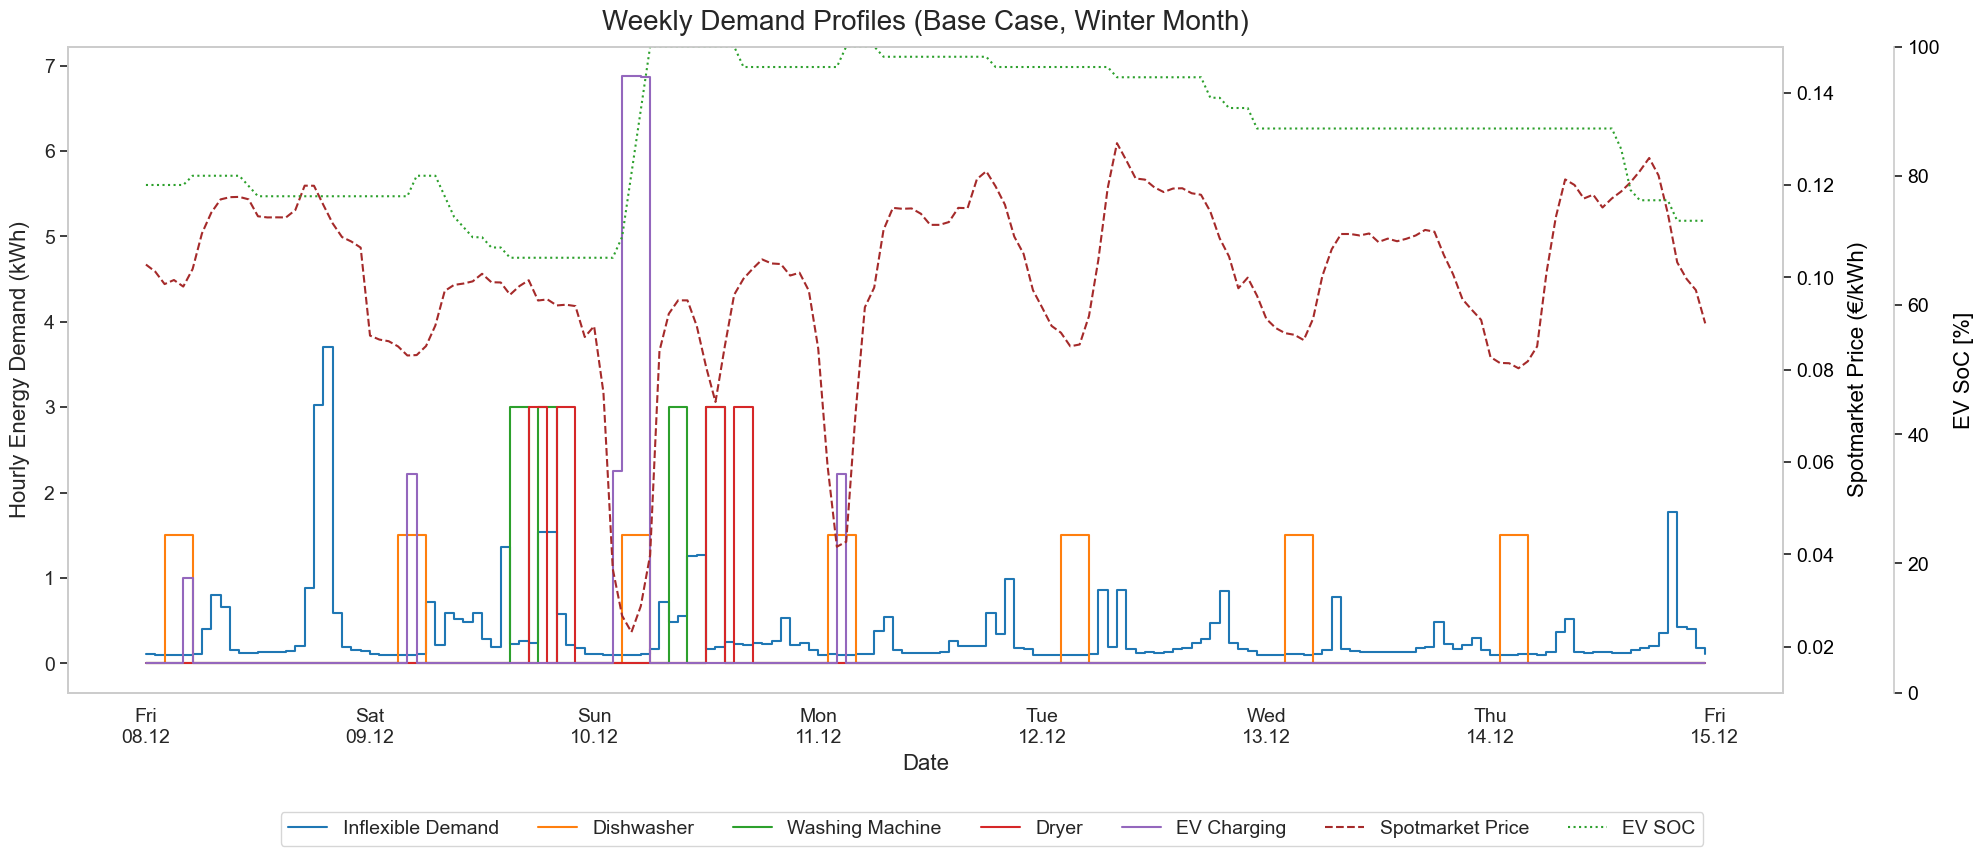

In [132]:
plot_title = "Weekly Demand Profiles (Base Case, Winter Month)"

filename = "basecase_winter.png"

start_day = 7
end_day = 14

plot_energy_profile(
    results_df=results_basecase_winter,
    title=plot_title,
    save_filename= filename,
    max_time=24 * end_day,
    min_time=24 * start_day,
)

### Plot Comparison Case 1 / 2 / 3 Winter

In [133]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import os

def plot_energy_profiles_comparison(
    results_list,
    titles,
    labels=None,
    save_filename="comparison_plot.png",
    min_time=0,
    max_time=24 * 7,
    power_dishwasher=1.5,
    power_wm=3,
    power_dryer=3,
    figsize=(20, 8),
):
    sns.set_theme(style="whitegrid")
    n = len(results_list)
    fig, axes = plt.subplots(ncols=n, sharey=True, figsize=figsize)
    fig.subplots_adjust(left=0.05, right=0.92, bottom=0.12, top=0.92, wspace=0.05)

    if labels is None:
        labels = [f"Case {i+1}" for i in range(n)]

    tech_handles = []
    tech_labels = []
    spot_line = None
    soc_line = None

    for idx, (results_df, ax) in enumerate(zip(results_list, axes)):
        results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])
        time_range = range(min_time, max_time)
        timestamps = results_df['timestamp'][min_time:max_time]

        binary_dishwasher = results_df['Dishwasher_On']
        binary_wm = results_df['Washing_Machine_On']
        binary_dryer = results_df['Dryer_On']
        soc_ev = results_df['EV_SOC']
        spot_price = results_df['Spotmarket_(EUR/kWh)']
        inflex_demand = results_df['Inflexible_Demand_(kWh)']
        charging_ev = results_df['EV_Charging']

        data_power = pd.DataFrame({
            'timestamp': timestamps,
            'Inflexible Demand': [inflex_demand[t] for t in time_range],
            'Deferrable Load': [power_dishwasher * binary_dishwasher[t] + power_wm * binary_wm[t] + power_dryer * binary_dryer[t] for t in time_range],
            'EV Charging': [charging_ev[t] for t in time_range]
        })

        if "Heatpump_Power" in results_df.columns:
            data_power['Heat Pump'] = [results_df["Heatpump_Power"][t] for t in time_range]

        if "PV_energy_production_kWh" in results_df.columns and idx != 0:
            data_power['PV Production'] = [results_df["PV_energy_production_kWh"][t] for t in time_range]

        data_power_melted = data_power.melt(
            id_vars='timestamp', var_name='Technology', value_name='Power (kWh)'
        )

        custom_palette = {
        'Inflexible Demand': '#1f77b4',
        'Deferrable Load': '#ff7f0e',
        'EV Charging': '#9467bd',
        'PV Production': '#e377c2',
        'Heat Pump': '#8c564b'
        }

        
        #palette = sns.color_palette("tab10", n_colors=len(data_power_melted['Technology'].unique()))
        palette = custom_palette
        show_legend = (idx == 0)
        lineplot = sns.lineplot(
            data=data_power_melted, x='timestamp', y='Power (kWh)', hue='Technology',
            ax=ax, palette=palette, drawstyle='steps-post', legend=show_legend
        )

        if show_legend:
            handles, labels_ = ax.get_legend_handles_labels()
            tech_handles = [h for h, l in zip(handles, labels_) if l != "Technology"]
            tech_labels = [l for l in labels_ if l != "Technology"]
            if ax.legend_:
                ax.legend_.remove()

        ax.set_xlabel("")
        ax.set_title(labels[idx], pad=12, fontsize=20)

        # Format timestamps for combined weekday and date label
        ticks = pd.date_range(
        start=timestamps.iloc[0].normalize(),
        end=timestamps.iloc[-1].normalize() + pd.Timedelta(days=1),freq='D'
        )

        tick_labels = [ts.strftime('%a\n%d.%m') for ts in ticks]
        ax.set_xticks(ticks)
        ax.set_xticklabels(tick_labels, fontsize=14)
        ax.tick_params(axis='x', pad=5, labelsize=14)
        ax.grid(False) 
        ax.xaxis.grid(False)  # disable vertical grid lines from explicit xticks


        if idx == 0:
            ax.set_ylabel("Energy Consumption / Generation (kWh)", labelpad=10, fontsize=16)
            ax.tick_params(axis='y', labelleft=True, labelsize=14)
        else:
            ax.set_ylabel("")
            ax.tick_params(axis='y', labelleft=False, length=0, labelsize=14)

        ax2 = ax.twinx()
        spot_line, = ax2.plot(
            timestamps, spot_price[min_time:max_time],
            '--', color='#a52a2a', label='Spotmarket Price'
        )
        ax2.set_ylim(0.01, 0.15)
        ax2.grid(False)

        if idx == n - 1:
            ax2.set_ylabel("Spotmarket Price (€/kWh)", color='black', labelpad=10, fontsize=16)
            ax2.tick_params(axis='y', labelcolor='black', labelsize=14)
        else:
            ax2.set_ylabel("")
            ax2.set_yticklabels([])
            ax2.tick_params(axis='y', labelright=False, length=0, labelsize=14)
            ax2.spines["right"].set_visible(False)

        # --- FAKE the zero alignment by forcing a padded left axis ---
        # Make energy axis start slightly below zero to match the taller SoC scale
        #   # Adjust this value if needed to match the visual baseline
        ax3 = ax.twinx()
        soc_line, = ax3.plot(
            timestamps, soc_ev[min_time:max_time] / 70 * 100,
            ':', color='#2ca02c', label='EV SoC %'
        )
        ax3.set_ylim(0, 100)
        ax3.grid(False)

        if idx == n - 1:
            ax3.spines["right"].set_position(("outward", 80))
            ax3.set_ylabel("EV SoC [%]", color='black', labelpad=10, fontsize=16)
            ax3.tick_params(axis='y', labelright=True, labelcolor='black', labelsize=14)
        else:
            ax3.set_ylabel("")
            ax3.set_yticklabels([])
            ax3.tick_params(axis='y', labelright=False, length=0, labelsize=14)
            ax3.spines["right"].set_visible(False)

    legend_items = tech_handles + [spot_line]
    legend_labels_combined = tech_labels + ['Spotmarket Price']
    if soc_line:
        legend_items.append(soc_line)
        legend_labels_combined.append('EV SOC')

    fig.legend(
        handles=legend_items,
        labels=legend_labels_combined,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.08),
        ncol=len(legend_labels_combined),
        fontsize=14,
        frameon=True
    )

    fig.supxlabel("Date", fontsize=16, x=0.489)
    #plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, save_filename), dpi=400, bbox_inches='tight')
    plt.show()

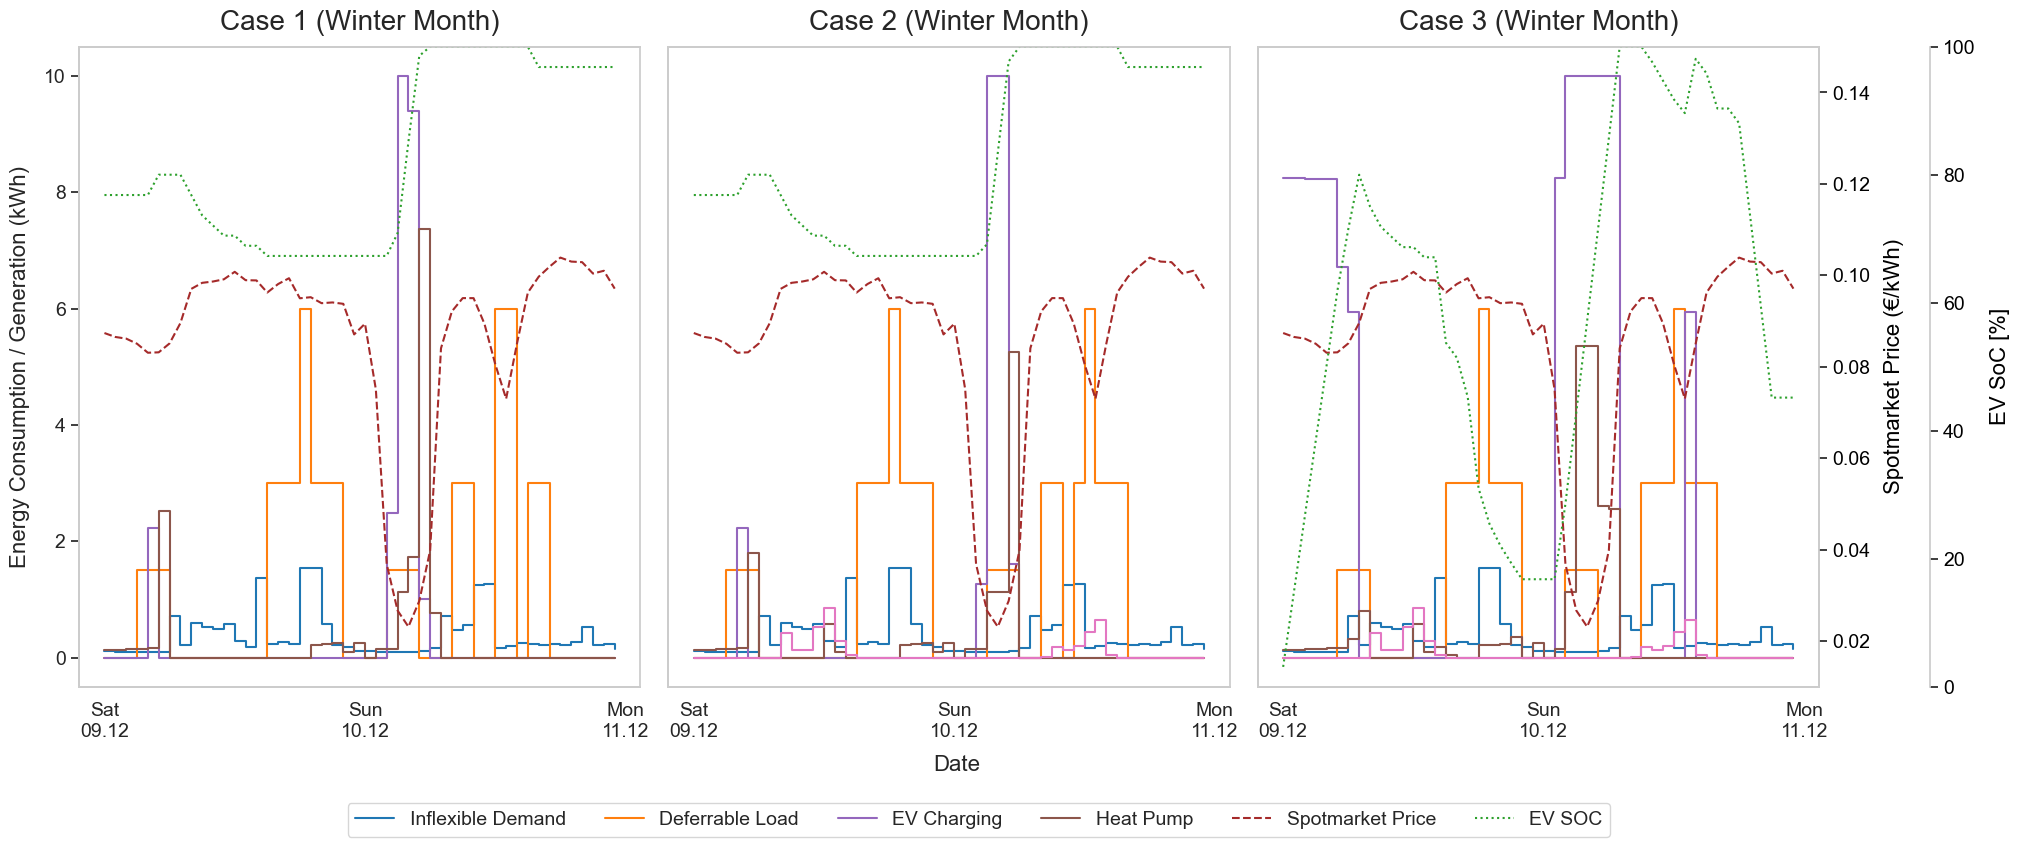

In [134]:
plot_energy_profiles_comparison(
    results_list=[results_case_1_winter, results_case_2_winter, results_case_3_winter],
    titles="Comparison of Weekly Demand Profiles (Winter)",
    labels=["Case 1 (Winter Month)", "Case 2 (Winter Month)","Case 3 (Winter Month)"],
    save_filename="winter_comparison.png",
    min_time=24*8,
    max_time=24*10
)

### Plot PV Comparison Case 2 - Case 3

In [135]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import os

def plot_pv_comparison(
    df1,
    df2,
    save_filename,
    min_time,
    max_time,
    figsize=(20, 8)
):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(ncols=2, sharey=True, figsize=figsize)
    fig.subplots_adjust(left=0, bottom=0.05, right=1, top=0.95, wspace=0.05)

    datasets = [df1, df2]
    labels = ["Case 2 - Curtailed & PV2H", "Case 3 - PV2G & PV2H"]
    energy_cols = [["Curtailed", "PV2H"], ["PV2G", "PV2H"]]
    color_map_list = [
        {"Curtailed": "tab:blue", "PV2H": "tab:green"},
        {"PV2G": "orange", "PV2H": "tab:green"},
    ]

    all_handles = []
    all_labels = []

    for idx, (df, ax, energy_set, title) in enumerate(zip(datasets, axes, energy_cols, labels)):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.iloc[min_time:max_time]
        timestamps = df['timestamp']

        # Plot energy lines manually to capture handles
        for col in energy_set:
            line, = ax.plot(
                timestamps,
                df[col],
                drawstyle='steps-post',
                label=col,
                color=color_map_list[idx][col]
            )
            all_handles.append(line)
            if col not in all_labels:
                all_labels.append(col)

        ax.set_ylabel("PV Generation [kWh]", fontsize=16)
        ax.set_xlabel("Date", fontsize=16, labelpad=5)
        ax.set_title(title, pad=12, fontsize=20)
        ax.grid(False)

        ticks = pd.date_range(
            start=timestamps.iloc[0].normalize(),
            end=timestamps.iloc[-1].normalize() + pd.Timedelta(days=1),
            freq='D'
        )
        tick_labels = [ts.strftime('%a\n%d.%m') for ts in ticks]
        ax.set_xticks(ticks)
        ax.set_xticklabels(tick_labels, fontsize=14)
        ax.tick_params(axis='x', pad=5, labelsize=14)
        ax.xaxis.grid(False)

        if idx == 1:
            ax.yaxis.set_visible(False)
            ax.spines["left"].set_visible(False)
        else:
            ax.tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=14)

        # Spotmarket price on twin axis
        ax2 = ax.twinx()
        spot_line, = ax2.plot(
            timestamps,
            df['Spotmarket_(EUR/kWh)'],
            '--',
            color='brown',
            label='Spotmarket Price'
        )
        ax2.set_ylim(0.01, 0.15)
        ax2.grid(False)

        if idx == 1:
            ax2.set_ylabel("Spotmarket Price (€/kWh)", color='black', labelpad=10, fontsize=16)
            ax2.tick_params(axis='y', labelright=True, labelcolor='black', labelsize=14)
        else:
            ax2.set_ylabel("")
            ax2.set_yticklabels([])
            ax2.tick_params(axis='y', labelright=False, length=0)
            ax2.spines["right"].set_visible(False)

        all_handles.append(spot_line)
        all_labels.append("Spotmarket Price")

        # Third axis: Unmet energy
        ax3 = ax.twinx()
        ax3.spines["right"].set_position(("outward", 80))
        unmet_line, = ax3.plot(
            timestamps,
            df["Unmet"],
            linestyle=':',
            color='red',
            linewidth=2,
            label='Unmet',
            drawstyle='steps-post'
        )
        # Set left axis limit explicitly (to preserve padding behavior)
        #ax.set_ylim(bottom=0)
        ax3.grid(False)

        if idx == 1:
            ax3.set_ylabel("Unmet Demand (kWh)", color='black', labelpad=10, fontsize=16)
            ax3.tick_params(axis='y', labelright=True, labelcolor='black', labelsize=14)
        else:
            ax3.set_ylabel("")
            ax3.set_yticklabels([])
            ax3.tick_params(axis='y', labelright=False, length=0)
            ax3.spines["right"].set_visible(False)

        all_handles.append(unmet_line)
        all_labels.append("Unmet Demand")

    # Deduplicate while preserving order
    seen = set()
    final_handles, final_labels = [], []
    for h, l in zip(all_handles, all_labels):
        if l not in seen:
            final_handles.append(h)
            final_labels.append(l)
            seen.add(l)

    # Move "Spotmarket Price" to the end
    if "Spotmarket Price" in final_labels:
        idx = final_labels.index("Spotmarket Price")
        spot_handle = final_handles.pop(idx)
        spot_label = final_labels.pop(idx)
        final_handles.append(spot_handle)
        final_labels.append(spot_label)

    # Global bottom legend
    fig.legend(
        handles=final_handles,
        labels=final_labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.16),
        ncol=len(final_labels),
        fontsize=14,
        frameon=True
    )

    plt.savefig(os.path.join(figures_dir, save_filename), dpi=400, bbox_inches='tight')
    plt.show()

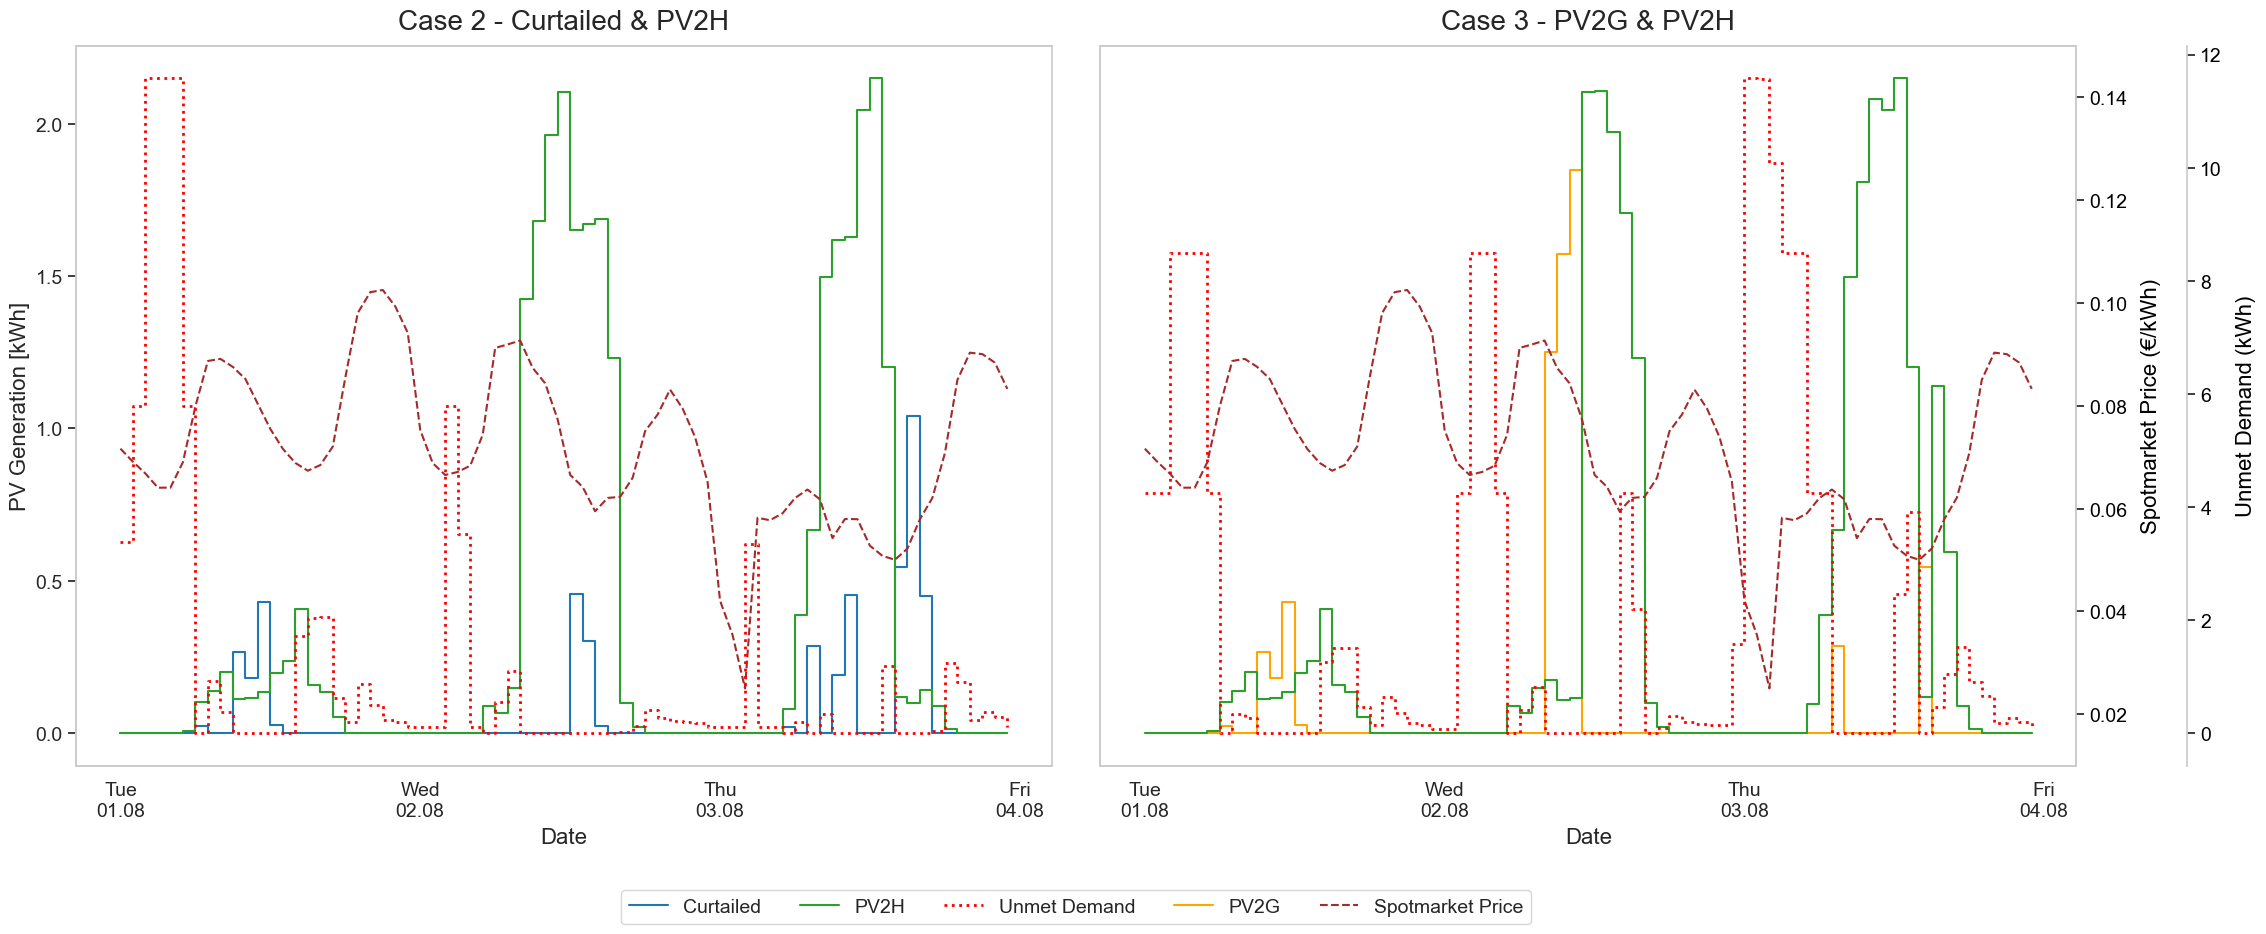

In [136]:
plot_pv_comparison(
    df1=results_case_2_summer,
    df2=results_case_3_summer,
    save_filename="PV_comparison.png",
    min_time=24 * 0,
    max_time=24 * 3,
)

### EV Dynamics all Cases and Case 3 

In [137]:
def plot_ev_soc_and_charging_side_by_side(
    df_dict,
    min_time,
    max_time,
    title_left="EV SOC with Spot Prices",
    title_right="EV Dynamics, Case 3",
    save_filename="SOC_and_EV_dynamics_side_by_side.png",
    ev_capacity_kwh=70
):
    base_df = df_dict["Base Case"]
    case_3 = df_dict['Case 3']
    base_df['timestamp'] = pd.to_datetime(base_df['timestamp'])
    timestamps = base_df['timestamp'][min_time:max_time]
    spotprice = base_df['Spotmarket_(EUR/kWh)'][min_time:max_time]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharex=True)
    fig.subplots_adjust(left=0, bottom=0.05, right=1, top=0.95, wspace=0.05)

    all_handles = []
    all_labels = []

    # ---- LEFT PLOT: EV SOC (%) ---- #
    palette = sns.color_palette("tab10", n_colors=len(df_dict))
    for i, (label, df) in enumerate(df_dict.items()):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        soc_line, = ax1.plot(
            df['timestamp'][min_time:max_time],
            df['EV_SOC'][min_time:max_time] / ev_capacity_kwh * 100,
            label=f"SOC – {label}",
            linewidth=2,
            color=palette[i]
        )
        all_handles.append(soc_line)
        all_labels.append(f"SOC – {label}")

    ax1.set_title(title_left, pad=12, fontsize=20)
    ax1.set_xlabel("Date", fontsize=16, labelpad=5)
    ax1.set_ylabel("State of Charge (%)", fontsize=16, color='black', labelpad=10)

    ticks = pd.date_range(
        start=timestamps.iloc[0].normalize(),
        end=timestamps.iloc[-1].normalize() + pd.Timedelta(days=1),freq='D'
        )

    tick_labels = [ts.strftime('%a\n%d.%m') for ts in ticks]
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(tick_labels, fontsize=14)
    ax1.tick_params(axis='x', pad=5, labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)
    ax1.grid(False) 

    # Spot price axis on LEFT (hidden ticks and labels)
    ax1b = ax1.twinx()
    spot_line_left, = ax1b.plot(
        timestamps, spotprice,
        linestyle='--', color='#a52a2a',
        linewidth=1.5
    )
    ax1b.set_ylabel("")
    ax1b.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)

    # ---- RIGHT PLOT ---- #
    soc = case_3['EV_SOC'][min_time:max_time] / ev_capacity_kwh * 100
    charging = case_3['EV_Charging'][min_time:max_time]

    # Spot price (visible on right)
    ax2b = ax2.twinx()
    spot_line_right, = ax2b.plot(
        timestamps, spotprice,
        linestyle='--', color='#a52a2a',
        linewidth=1.5
    )
    ax2b.set_ylabel("Spot Price (EUR/kWh)", color='black', fontsize=16, labelpad=10)
    ax2b.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax2b.set_ylim(0.01, 0.15)


    # EV charging (third axis on far right)
    ax2c = ax2.twinx()
    ax2c.spines['right'].set_position(('outward', 60))
    charging_bar = ax2c.bar(
        timestamps,
        charging,
        width=0.03,
        label="EV Dis-/charging (kWh)",
        color="#4c72b0",
        alpha=0.4
    )
    ax2c.set_ylabel("EV Dis-/charging (kWh)", fontsize=16, color='black', labelpad=10)
    ax2c.tick_params(axis='y', labelsize=14)

    case_3_index = list(df_dict.keys()).index("Case 3")
    case_3_color = palette[case_3_index]

    soc_line_right, = ax2.plot(
        timestamps, soc,
        label="SOC – Case 3",
        color=case_3_color,
        linewidth=2
    )

    ax2.set_title(title_right, pad=12, fontsize=20)
    ax2.set_xlabel("Date", fontsize=16, labelpad=5)
    ax2.set_ylabel("", fontsize=16, color='black', labelpad=10)
    ax2.tick_params(axis='y', left=False, labelleft=False)
    ax2.set_xticks(ticks)
    ax2.set_xticklabels(tick_labels, fontsize=14)
    ax2.tick_params(axis='x', pad=5, labelsize=14)
    ax2.grid(False) 
    

    ax2c.spines["right"].set_position(("outward", 80))

    ax2c.set_ylabel("EV Dis-/charging (kWh)", fontsize=16, color='black', labelpad=10)
    ax2c.tick_params(axis='y', labelcolor='black', labelsize=14)


    # ---- Combine legend entries ---- #
    all_handles.extend([spot_line_right, charging_bar])
    all_labels.extend(["Spot Price", "EV Charging"])

    discharging = (case_3['EV_V2G'][min_time:max_time] + case_3['EV_V2H'][min_time:max_time])  # make negative for downward bars

    # Add discharging bar to same axis as charging (ax2c)
    discharging_bar = ax2c.bar(
        timestamps,
        discharging,
        width=0.03,
        label="EV Discharging (kWh)",
        color="#e17c05",  # orange-ish
        alpha=0.5
    )

    # Add to legend
    all_handles.append(discharging_bar)
    all_labels.append("EV Discharging")

    # Add EV-at-home status as a horizontal strip on both plots
    home_status = case_3['ev_at_home_binary'][min_time:max_time]
    home_colors = ['lightgreen' if val == 1 else 'lightcoral' for val in home_status]

    # Bar height and position (just above x-axis)
    home_y = -5  # % for SOC (Y-axis), safe bottom placement
    bar_height = 2  # thin band

    # Left plot – use same timestamps
    for i, ts in enumerate(timestamps):
        ax1.bar(ts, bar_height, bottom=home_y, width=0.03, color=home_colors[i], align='center', linewidth=0)

    # Right plot – same logic
    for i, ts in enumerate(timestamps):
        ax2.bar(ts, bar_height, bottom=home_y, width=0.03, color=home_colors[i], align='center', linewidth=0)
    
    import matplotlib.patches as mpatches
    home_patch = mpatches.Patch(color='lightgreen', label='EV at Home')
    away_patch = mpatches.Patch(color='lightcoral', label='EV Away')
    all_handles.extend([home_patch, away_patch])
    all_labels.extend(['EV at Home', 'EV Away'])
    

    # Combine EV discharging from V2G and V2H
    


    # ---- Shared horizontal legend below both plots ---- #
    fig.legend(
        handles=all_handles,
        labels=all_labels,
        loc='lower center',
        ncol=8,
        fontsize=14,
        bbox_to_anchor=(0.5, -0.16)
    )


    # Turn off gridlines for all axes
    ax1.grid(False)
    ax1b.grid(False)
    ax2.grid(False)
    ax2b.grid(False)
    ax2c.grid(False)

    #plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for legend

    if 'figures_dir' in globals():
        plt.savefig(os.path.join(figures_dir, save_filename), dpi=400, bbox_inches='tight')
    else:
        plt.savefig(save_filename, dpi=400, bbox_inches='tight')

    plt.show()

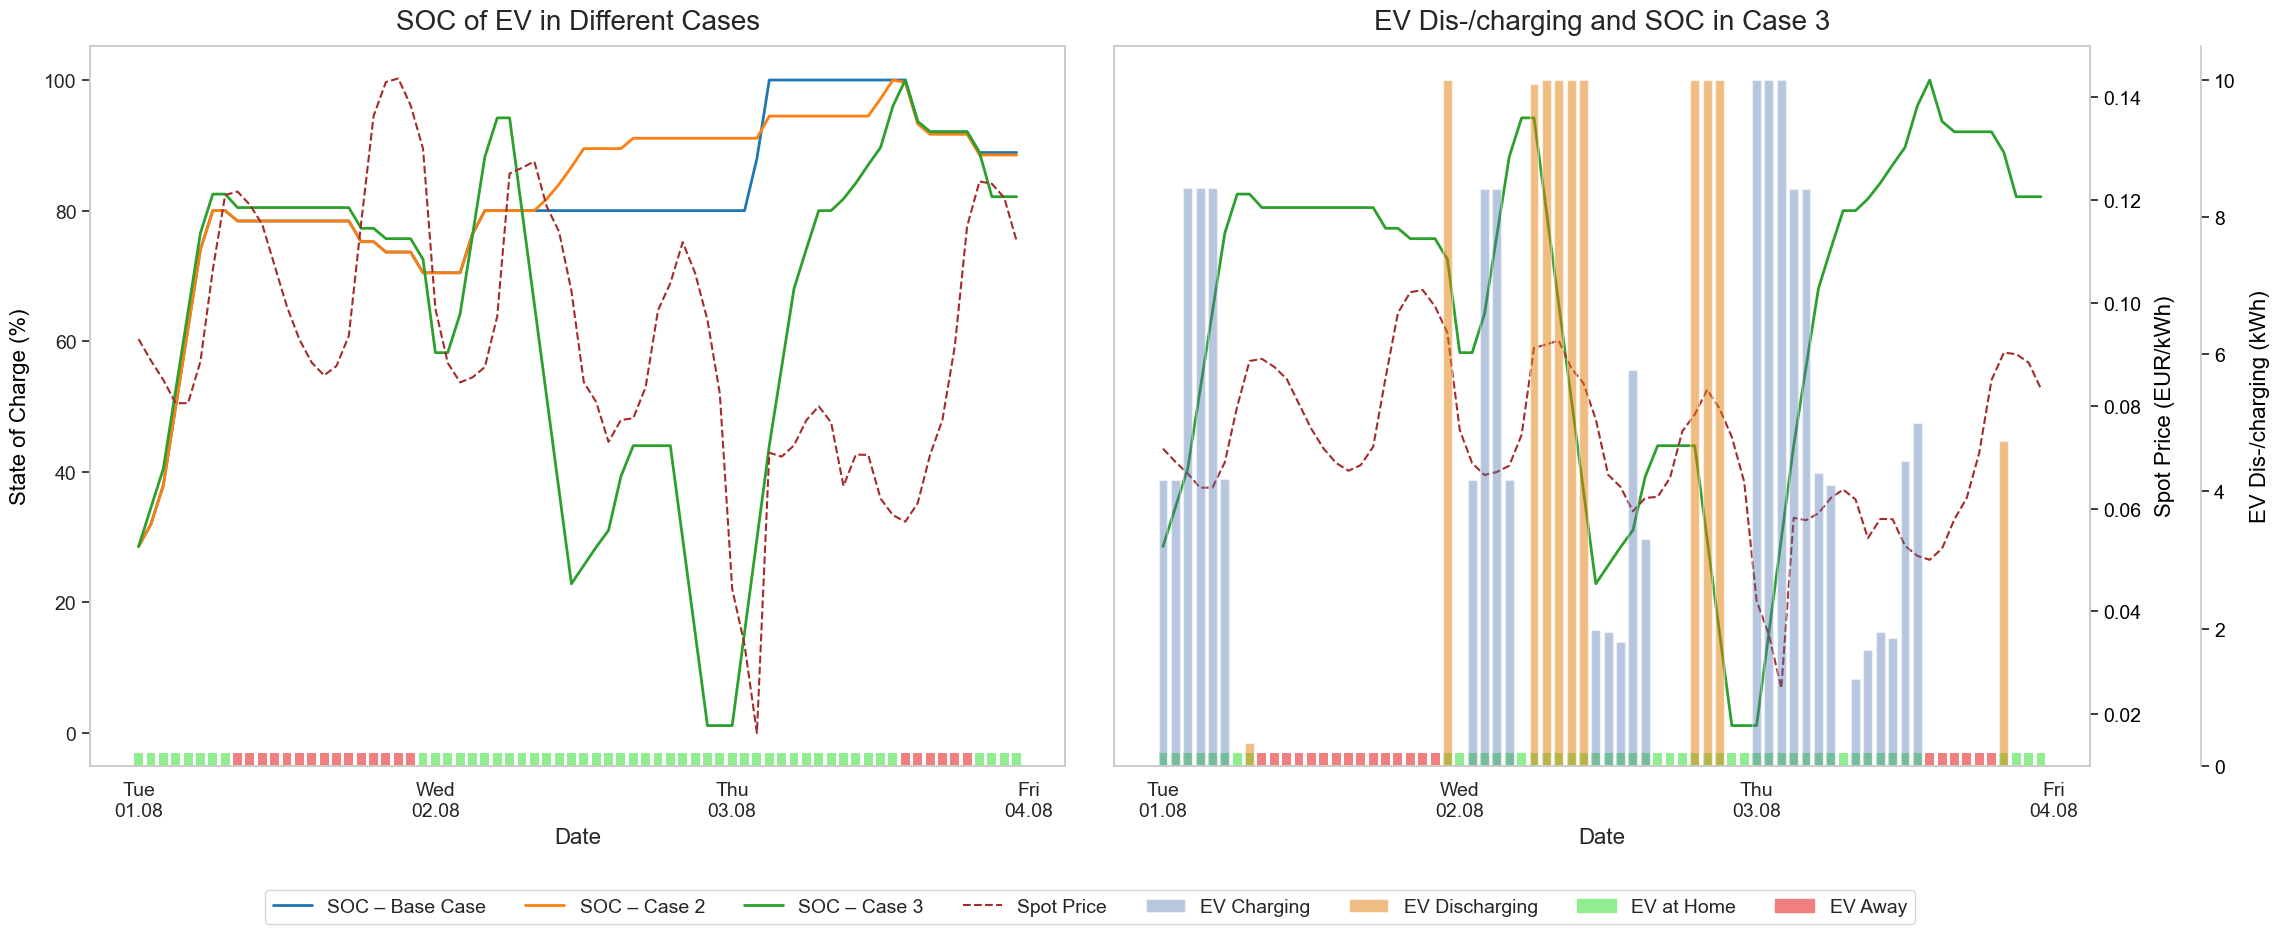

In [138]:
df_dict = {
    "Base Case": results_basecase_summer,
    #"Case 1": results_case_1_summer,
    "Case 2": results_case_2_summer,
    "Case 3": results_case_3_summer
}

end_day = 3
start_day = 0

plot_ev_soc_and_charging_side_by_side(
    df_dict,
    min_time=24 * start_day,
    max_time=24 * end_day, # 3 days
    title_left="SOC of EV in Different Cases",
    title_right="EV Dis-/charging and SOC in Case 3",
    save_filename="SOC_and_charging_cases.png",
)

In [139]:
def plot_objective_values(objective_values):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 8))

    # Group values by case name (Basecase, Case 1, etc.)
    grouped = {}
    for key, value in objective_values.items():
        case, season = key.rsplit(' ', 1)
        if case not in grouped:
            grouped[case] = {}
        grouped[case][season] = value

    # Prepare bar positions and data
    heights = []
    positions = []
    case_labels = []
    season_labels = []
    bar_width = 0.35
    position = 0

    for case in grouped:
        seasons = grouped[case]
        if "Summer" in seasons:
            heights.append(seasons["Summer"])
            positions.append(position)
            season_labels.append("Summer")
            case_labels.append(case)
            position += bar_width
        if "Winter" in seasons:
            heights.append(seasons["Winter"])
            positions.append(position)
            season_labels.append("Winter")
            case_labels.append(case)
            position += bar_width
        position += bar_width  # spacing between groups

    # Bar plot
    bars = ax.bar(positions, heights, width=bar_width, color='orange')

    # Annotate bars
    for bar in bars:
        yval = bar.get_height()
        offset = 0.5 if yval >= 0 else -1.5
        va = 'bottom' if yval >= 0 else 'top'
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval + offset,
            f"{yval:.2f}",
            ha='center',
            va=va,
            fontsize=10
        )

    # First-level x-tick: Season (moved below axis)
    ax.set_xticks(positions)
    ax.set_xticklabels(season_labels, fontsize=14)
    ax.tick_params(axis='x', which='both', direction='out', pad=10, labelsize=14)

    # Second-level x-tick: Case (placed manually in the middle of each group)
    group_centers = []
    case_seen = set()
    for i, (case, season) in enumerate(zip(case_labels, season_labels)):
        if case not in case_seen:
            count = sum(1 for c in case_labels if c == case)
            start_idx = i
            group_pos = sum(positions[start_idx:start_idx + count]) / count
            group_centers.append((group_pos, case))
            case_seen.add(case)

    min_val = min(heights)
    label_y = min(ax.get_ylim()[0], min_val - 8)  # push labels lower

    xlim = ax.get_xlim()
    xrange = xlim[1] - xlim[0]

    for pos, label in group_centers:
        x_frac = (pos - xlim[0]) / xrange
        ax.annotate(label, xy=(x_frac, -0.08), xycoords='axes fraction',
                    ha='center', va='top', fontsize=16)

    # Adjust y-limits to accommodate negative bars and labels
    ax.set_ylim(bottom=-8)


    # Final plot settings
    ax.set_title("Objective Values for Different Cases", fontsize=20, pad=12)
    ax.set_xlabel("", fontsize=16, labelpad=5)
    ax.set_ylabel("Objective Value (EUR/Month)", fontsize=16, labelpad=10)
    ax.tick_params(axis='x', which='both', length=0, labelsize=14)
    ax.grid(False)
    ax.axhline(0, color='black', linewidth=1)
    plt.tight_layout()

    plt.savefig(os.path.join(figures_dir, "objective_values_comparison.png"), dpi=400, bbox_inches='tight')
    plt.show()

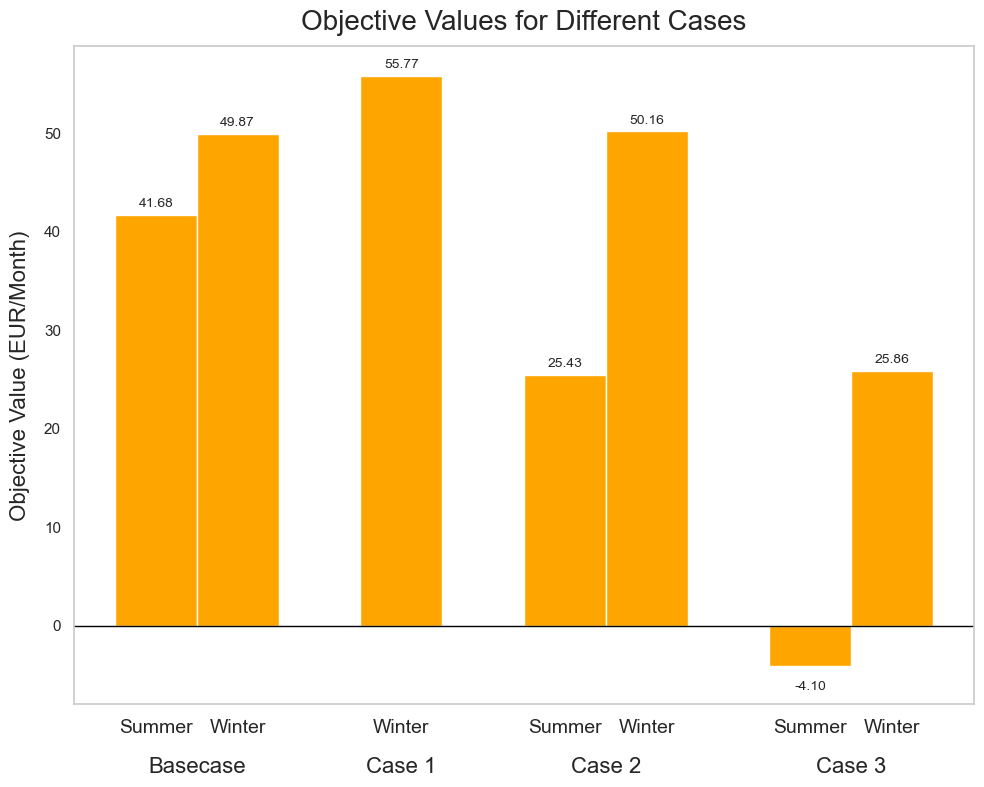

In [140]:
objective_values = {
    "Basecase Summer": 41.67957787311,
    "Basecase Winter": 49.87230553270,
    "Case 1 Winter": 55.76806647406,
    "Case 2 Summer": 25.42661940101,
    "Case 2 Winter": 50.16425672432,
    "Case 3 Summer": -4.102351746385,
    "Case 3 Winter": 25.86141790305
}

plot_objective_values(objective_values)